In [ ]:

import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import PIL.Image
import io

# For webcam capture in Colab
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ===========================
# 📌 Extract Brain Tumor Dataset
# ===========================
import zipfile

zip_path = "/content/drive/MyDrive/brain_tumor.zip"  # Upload the dataset to Colab
extract_path = "/content/brain_tumor_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset Extracted Successfully!")


✅ Dataset Extracted Successfully!


In [ ]:
# ===========================
# 📌 Load & Preprocess Dataset
# ===========================
X = []
Y = []
image_size = 150
# Updated labels to match the expected folder structure
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for label in labels:
    folderPath = os.path.join('/content/brain_tumor_data/Training', label)
    for path in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, path))
        img = cv2.resize(img, (image_size, image_size))  # Resize to 150x150
        X.append(img)
        Y.append(labels.index(label))  # Convert labels to numbers

# Convert lists to NumPy arrays
X = np.array(X) / 255.0  # Normalize images
Y = tf.keras.utils.to_categorical(np.array(Y))  # One-hot encode labels

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

print("✅ Data Loaded & Preprocessed Successfully!")

✅ Data Loaded & Preprocessed Successfully!


In [ ]:
# ===========================
# 📌 Define CNN Model
# ===========================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    14,746,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,325,508 (58.46 MB)

 Trainable params: 15,325,508 (58.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ===========================
# 📌 Train the CNN Model
# ===========================
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')
lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=3, factor=0.5, min_lr=1e-6)
mc = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

callback = [es, lr, mc]

history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test), callbacks=callback)


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.3678 - loss: 1.2999

72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 320ms/step - accuracy: 0.3692 - loss: 1.2980 - val_accuracy: 0.6429 - val_loss: 0.7907 - learning_rate: 0.0010
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6578 - loss: 0.8241

72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.6579 - loss: 0.8236 - val_accuracy: 0.7544 - val_loss: 0.6070 - learning_rate: 0.0010
Epoch 3/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7449 - loss: 0.5985

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.7449 - loss: 0.5987 - val_accuracy: 0.7909 - val_loss: 0.4886 - learning_rate: 0.0010
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7980 - loss: 0.4913

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.7982 - loss: 0.4911 - val_accuracy: 0.8240 - val_loss: 0.4784 - learning_rate: 0.0010
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8596 - loss: 0.3689 - val_accuracy: 0.8031 - val_loss: 0.4945 - learning_rate: 0.0010
Epoch 6/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8859 - loss: 0.2940

72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.8861 - loss: 0.2938 - val_accuracy: 0.8571 - val_loss: 0.5046 - learning_rate: 0.0010
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9277 - loss: 0.1858

72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9276 - loss: 0.1861 - val_accuracy: 0.8763 - val_loss: 0.4147 - learning_rate: 0.0010
Epoch 8/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9380 - loss: 0.1752

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9381 - loss: 0.1749 - val_accuracy: 0.8815 - val_loss: 0.3839 - learning_rate: 0.0010
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9570 - loss: 0.1095 - val_accuracy: 0.8676 - val_loss: 0.3682 - learning_rate: 0.0010
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9569 - loss: 0.1219 - val_accuracy: 0.8815 - val_loss: 0.4428 - learning_rate: 0.0010
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9613 - loss: 0.1094 - val_accuracy: 0.8641 - val_loss: 0.4939 - learning_rate: 0.0010
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9809 - loss: 0.0549

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9809 - loss: 0.0547 - val_accuracy: 0.9007 - val_loss: 0.3868 - learning_rate: 5.0000e-04
Epoch 13/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9918 - loss: 0.0261

72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9918 - loss: 0.0261 - val_accuracy: 0.9077 - val_loss: 0.4414 - learning_rate: 5.0000e-04
Epoch 14/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9957 - loss: 0.0135 - val_accuracy: 0.9077 - val_loss: 0.4839 - learning_rate: 5.0000e-04
Epoch 15/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9967 - loss: 0.0097 - val_accuracy: 0.9059 - val_loss: 0.5646 - learning_rate: 5.0000e-04
Epoch 16/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9911 - loss: 0.0224 - val_accuracy: 0.8833 - val_loss: 0.5696 - learning_rate: 5.0000e-04
Epoch 17/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9885 - loss: 0.0401 - val_accuracy: 0.9059 - val_loss: 0.4920 - learning_rate: 2.5000e-04
Epoch 18/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9945 - loss: 0.0180 - val_accuracy: 0.9077 - val_loss: 0.4669 - learning_rate: 2.5000e-04


In [ ]:
# ===========================
# 📌 Evaluate Model
# ===========================
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"✅ Model Test Accuracy: {test_accuracy * 100:.2f}%")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8987 - loss: 0.4840
✅ Model Test Accuracy: 90.77%


In [ ]:
# ===========================
# 📌 Webcam Image Capture
# ===========================
def take_photo(filename='captured_image.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture Image';
            div.appendChild(capture);
            document.body.appendChild(div);

            const video = document.createElement('video');
            video.style.display = 'block';
            document.body.appendChild(video);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getTracks().forEach(track => track.stop());
            video.remove();
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

image_path = take_photo()


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


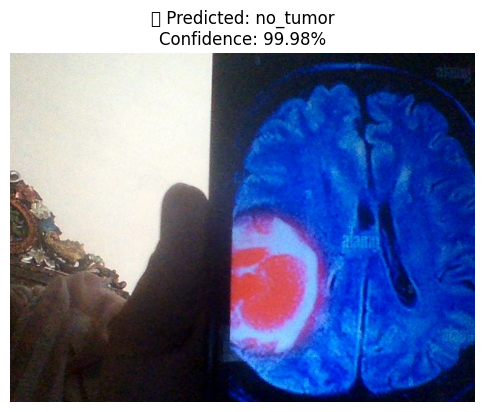

✅ Model Prediction: **no_tumor**
🔍 Confidence Score: **99.98%**


In [ ]:
# ===========================
# 📌 Preprocess Captured Image
# ===========================
def preprocess_image(image_path):
    img = PIL.Image.open(image_path)
    img = img.resize((150, 150))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

image = preprocess_image(image_path)

# ===========================
# 📌 Load Trained Model
# ===========================
model = load_model("best_model.h5")

# ===========================
# 📌 Predict Tumor Type
# ===========================
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
prediction = model.predict(image)
predicted_label = labels[np.argmax(prediction)]
confidence = np.max(prediction) * 100

# ===========================
# 📌 Display Prediction
# ===========================
plt.figure(figsize=(6,6))
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.title(f"🔍 Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
plt.show()

print(f"✅ Model Prediction: **{predicted_label}**")
print(f"🔍 Confidence Score: **{confidence:.2f}%**")


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
model.save("best.keras")


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2

# Load the trained model
model = tf.keras.models.load_model('best.keras')

# Define class labels
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Image preprocessing function
def preprocess_image(image):
    image = cv2.resize(image, (150, 150))  # Resize to match model input size
    image = np.array(image, dtype=np.float32) / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Prediction function
def predict(image):
    image = preprocess_image(image)
    prediction = model.predict(image)
    predicted_label = labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    return f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}%"

# Gradio UI
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),  # Accepts image input
    outputs="text",  # Outputs prediction result
    title="Brain Tumor Detection",
    description="Upload or capture an MRI image to detect brain tumor."
)

# Launch the interface
iface.launch(debug=True)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4fedddc5c0031f7e9b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
